# Gap filling for streamflow records 

based off of design of: https://www.hatarilabs.com/ih-en/fill-missing-precipitation-data-with-artificial-intelligence-python-keras-tutorial

In [92]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))


#%matplotlib inline
%matplotlib notebook
import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import datetime
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf

pd.set_option('display.max_rows', 200)    
np.set_printoptions(suppress=True)


# Raw data Paths
using Streamflow data direclty obtained from cshuler/ASPA-UH_Integrated_Modeling_Framework

In [2]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Stream_REPO/workspace/All_consolodated_Q_m3ps.csv"
save_to = os.path.join(".", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16200025

# read in data and convert to daily average values

<IPython.core.display.Javascript object>


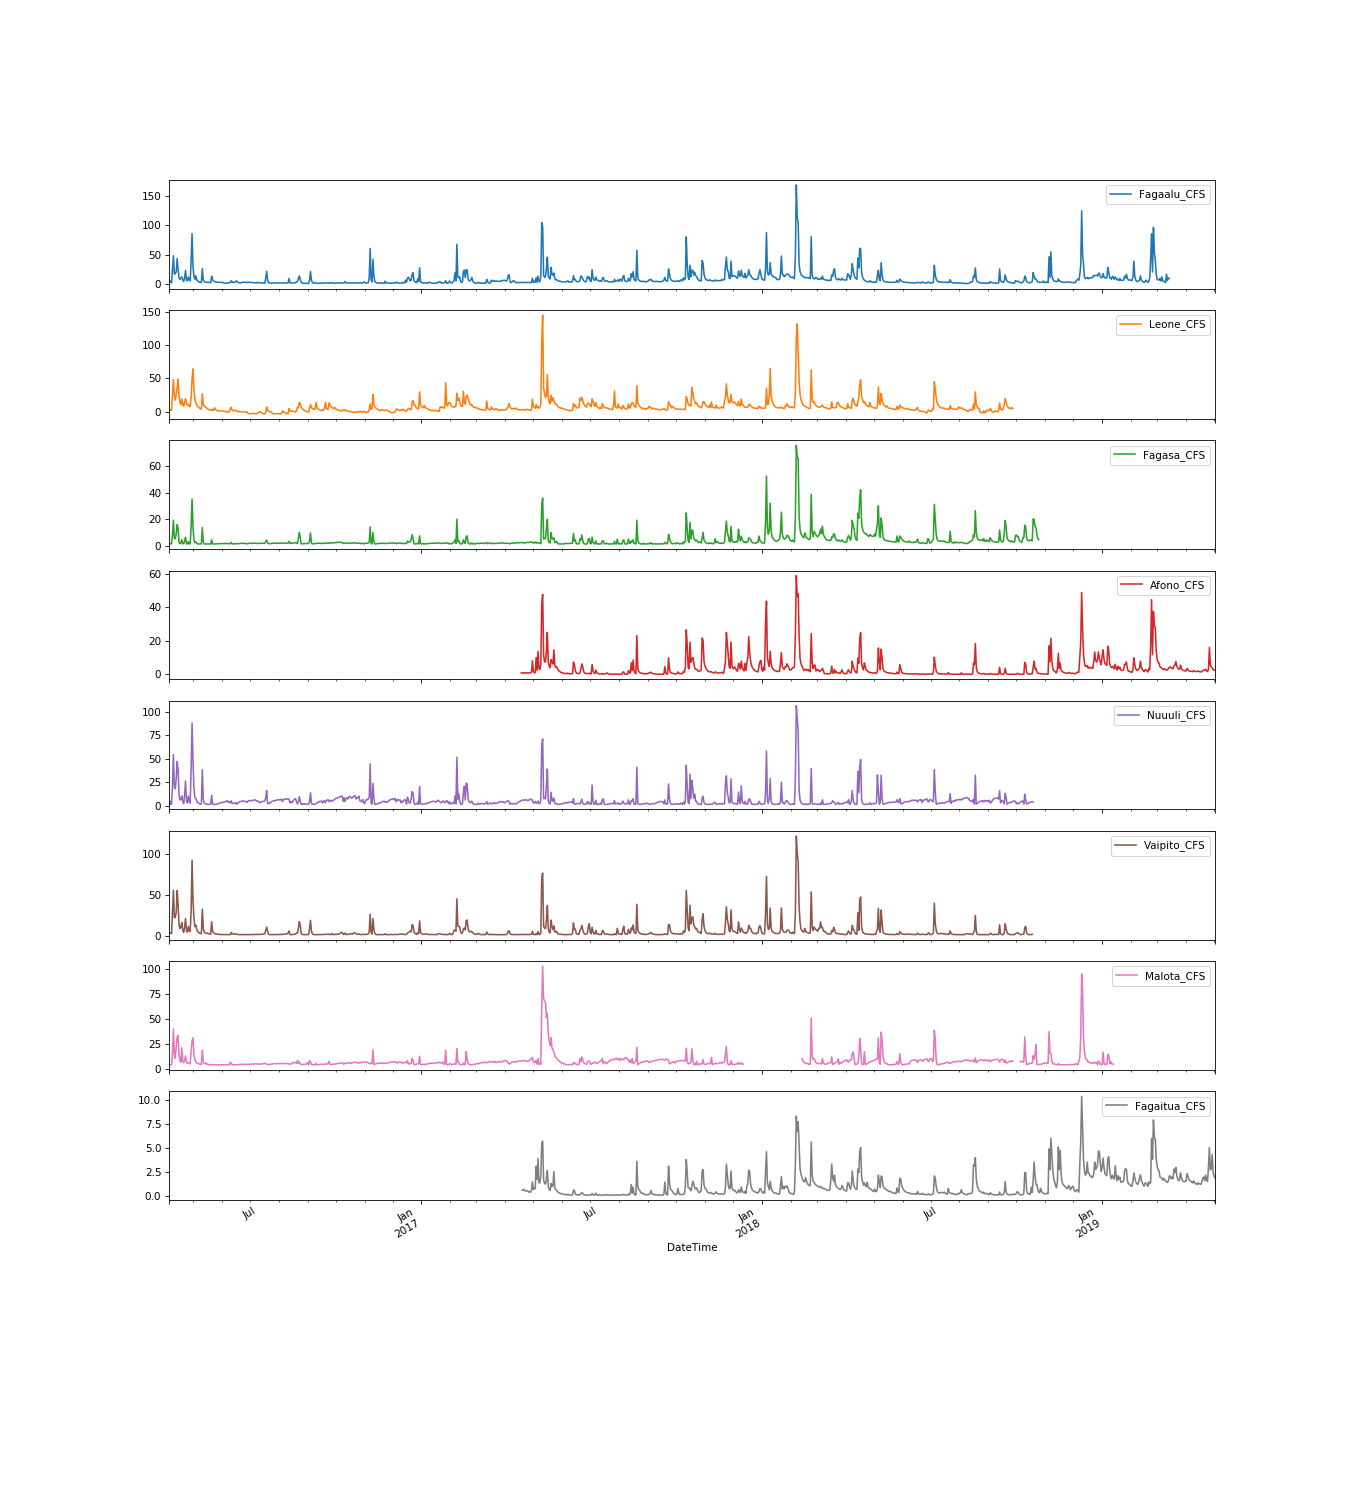

In [84]:
rawdata = pd.read_csv(save_to ,index_col=0,parse_dates=True)

dat = rawdata.resample('D').mean()     # subsample the 15 min data into daily values
dat = dat[8:]                          # this just to cut out some of the beginning days with no streamflows

data = pd.DataFrame(index=dat.index)
for column in dat:
    new_name = column.split("_")[0]+"_CFS"
    data[new_name] = dat[column]*35.314666212661 
    
data.plot(subplots=True, figsize=(18, 20))
plt.legend(loc='best')

# examine corelation matrix to see relationships between stations 

note that maloata station is poorly correlated, this is likey due to the station being messed up, so remove it. 


<IPython.core.display.Javascript object>


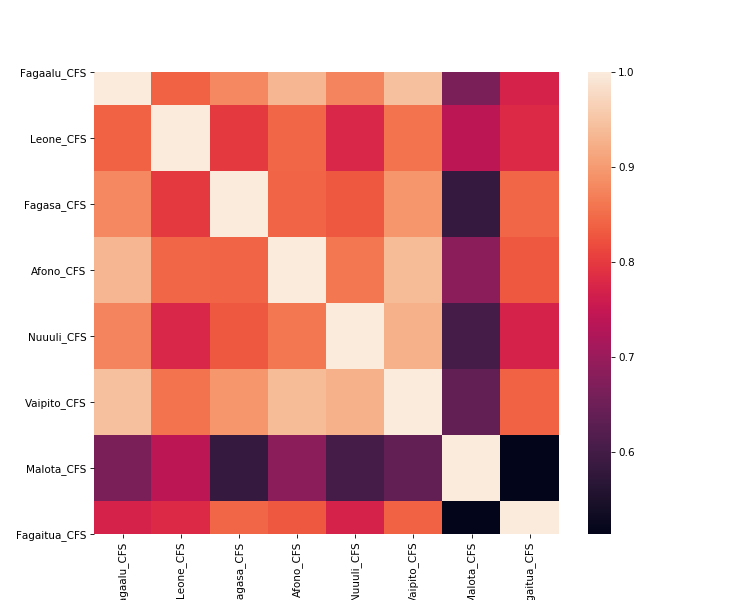

In [4]:
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

<IPython.core.display.Javascript object>


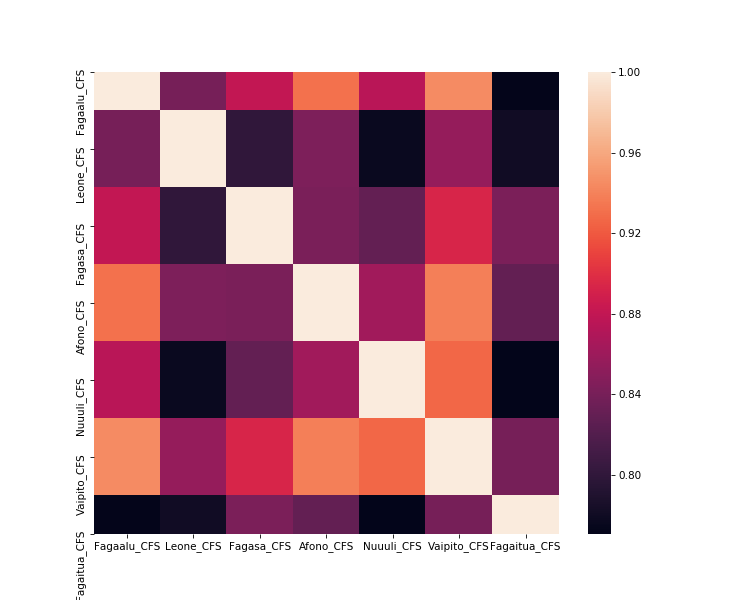

In [5]:
## remove Maloata from data  new plot
data = data.loc[:, data.columns != 'Malota_CFS']

plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr,  xticklabels=data.columns.values, yticklabels=data.columns.values)

### determine what proportion of data is misssing. This will be used to praramaterize the validation exercise

In [87]:
data_date_range = data.index.max()-data.index.min()
pct_existing_list=[]

for i in data: 
    tempframe = data[i]
    tempframe = tempframe.dropna()
    temp_day_count = tempframe.index.max()-tempframe.index.min()
    pct_existing = temp_day_count/data_date_range
    pct_existing_list.append(pct_existing)
    
Ave_amount_existing_data = np.mean(pct_existing_list)

In [88]:
# Fix the random seed for reproducibility
np.random.seed(696007)
tf.set_random_seed(696007)

# Validation  and uncertainty assessment 
##  1) validate effectiveness of gap filling 
##  2) develop appropriate DL netork parameters for  gap filling of actual missing data

### Loop over all stations, train on part of data, predict on other half to:

Note, sometimes this fails, and the network doesn't predict anything. not sure why. if it does it will automatically re-run until it succeeeds

In [95]:
Ave_amount_existing_data = .2

### Clean up dataset 

<IPython.core.display.Javascript object>


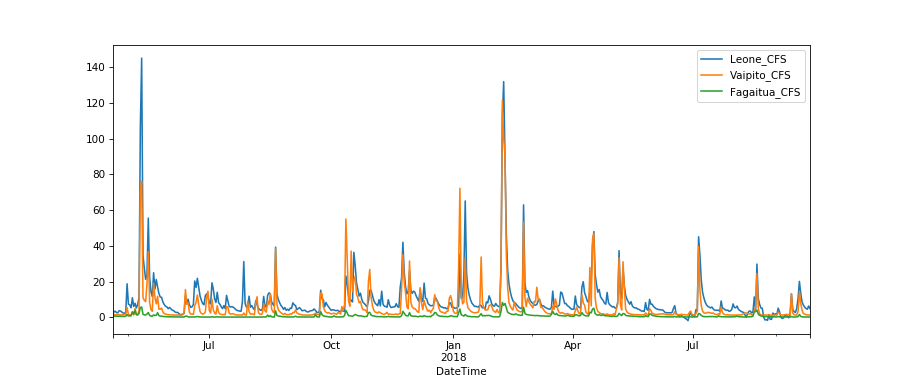

In [89]:
# make sure that maloata is gone
data = data.loc[:, data.columns != 'Malota_CFS']
data = data.loc[:, data.columns != 'Fagaalu_CFS']
data = data.loc[:, data.columns != 'Nuuuli_CFS']
data = data.loc[:, data.columns != 'Fagasa_CFS']
data = data.loc[:, data.columns != 'Afono_CFS']

# just select perfect no gap dataset 
data_all = data.dropna()

data_all.plot(subplots=False, figsize=(12, 5))
plt.legend(loc='best')

# original dont mess up 

gap filling for station Leone_CFS
Training with stations ['Vaipito_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


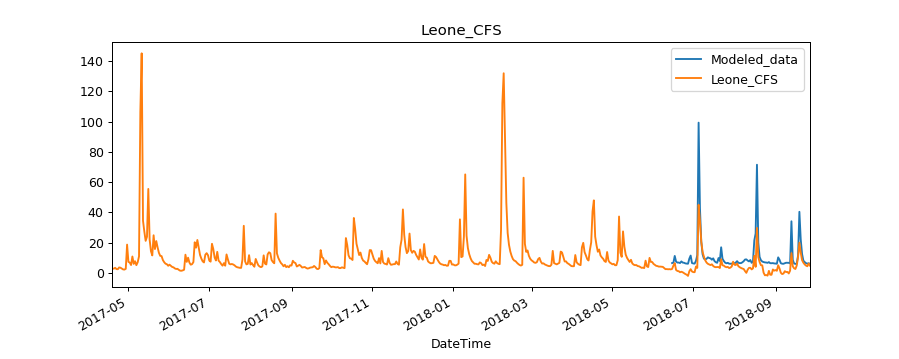

<IPython.core.display.Javascript object>


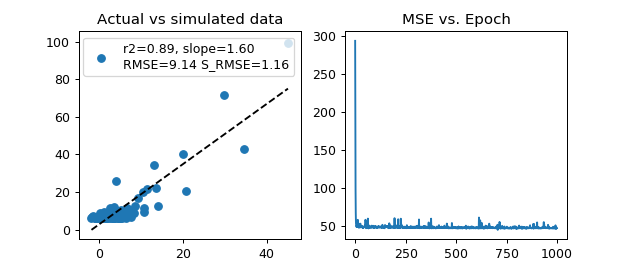

RMSE Error=9.14    r2=0.89    slope=1.60    Std_RMSE=1.16


gap filling for station Vaipito_CFS
Training with stations ['Leone_CFS', 'Fagaitua_CFS']


<IPython.core.display.Javascript object>


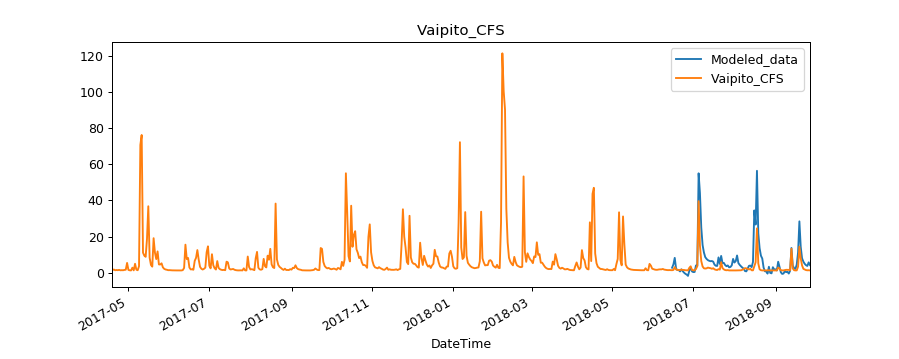

<IPython.core.display.Javascript object>


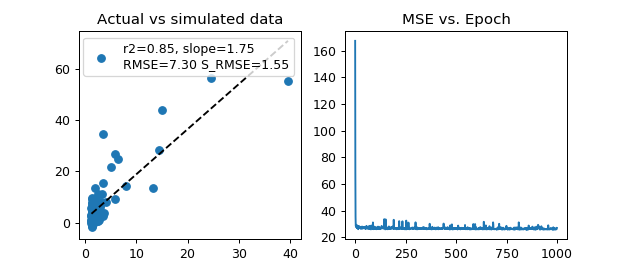

RMSE Error=7.30    r2=0.85    slope=1.75    Std_RMSE=1.55


gap filling for station Fagaitua_CFS
Training with stations ['Leone_CFS', 'Vaipito_CFS']


<IPython.core.display.Javascript object>


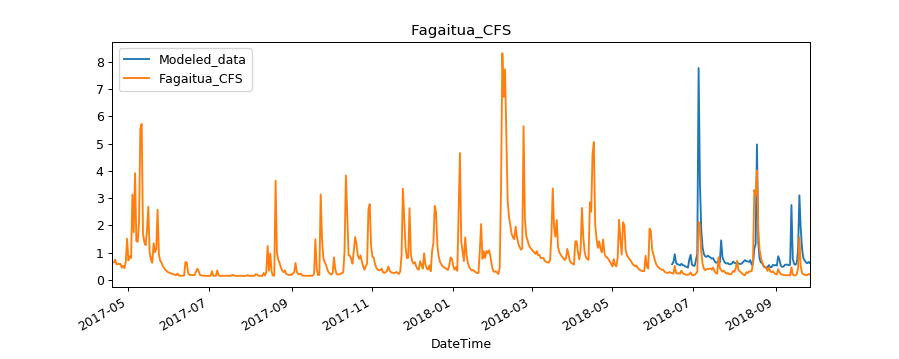

<IPython.core.display.Javascript object>


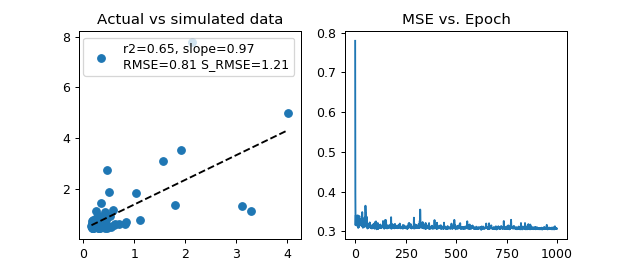

RMSE Error=0.81    r2=0.65    slope=0.97    Std_RMSE=1.21


OVERALL RMSE = 5.750428544320076
OVERALL Std_RMSE = 1.3042075151648773
OVERALL r2 = 0.7958853853974418
OVERALL Slope = 1.440701156454523


In [96]:

plt.close("all")  # close previous figures to clear  memory
station_list = list(data_all.columns)                        # all the stations to examine 


should_restart = True      # THIS WHILE LOOP WILL RESTART THE for loop if one of the stations fails (fail = slope is 0), then it will terminate once all the stations have completed without failing  
while should_restart:
    should_restart = False
    
    SRMSE_list=[]; slope_list=[];r2_list=[]; RMSE_list=[]            # containers for the error statistics
    plt.close("all")  # close previous figures to clear memory
    
    for i in station_list:
        trainlist = station_list.copy()                 # the list of all the other stations with which to use to train the network
        trainlist.remove(i)                             # remove the one station that is being gappped, all others are used for training
        print("gap filling for station {}".format(i))
        print("Training with stations {}".format(trainlist))

        # some math to be able to select a portion of the dataset, based upon a percentage (0-1) of the data we want to remove   ( can loop over how_much_to_delete variable later)
        n = len(data_all[i])
        how_much_to_delete = Ave_amount_existing_data                      # Has to be   0 < x < 1  cant be 0 or 1. (actually deletes the inverse of the %exsiting list)
        stop_idx = n-int((how_much_to_delete)*n)
        Train_End = data_all.index[stop_idx]                # end of the training data period, i.e. training data omits data after this data 
        Train_Start = data_all.index[0]                      # start of the training data period (always the beginning of data all 

        X_train = data_all.loc[Train_Start:Train_End,trainlist].values             
        y_train = data_all.loc[Train_Start:Train_End,i].values  

        #scale values appropriately
        scaler = StandardScaler().fit(X_train)   # Define the scaler 
        X_train = scaler.transform(X_train)      # Scale the train set

        
# initialize the deep learning model 
        model = Sequential()

        model.add(Dense(20, activation='linear', input_shape=(len(trainlist),)))
        model.add(Dense(50, activation='linear'))
        model.add(Dense(100, activation='linear'))
        model.add(Dense(1, activation='linear'))
        #model.summary()

# train the network using data from the one station
        model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
        #model.compile(loss='mean_squared_error',  optimizer='Nadam',  metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=1000, verbose=0)

    # now run the network on data not used for training to validate effacacy

        Predict_Start = data_all.index[(stop_idx)]                # Start of the validatiaon data period, = end of training data 
        Predict_End = data_all.index[-1]                      # end of the validation data period (always the end of data all)

        X_predict_known = data_all.loc[Predict_Start:Predict_End,trainlist].values 
        #scale values appropriately
        scaler = StandardScaler().fit(X_predict_known)   # Define the scaler 
        X_predict_known = scaler.transform(X_predict_known) # Scale the train set

        y_predict_unknown = model.predict(X_predict_known)
        y_predict_unknown = y_predict_unknown.reshape([np.shape(y_predict_unknown)[0]]).tolist()

        y_real_data = data_all[i].loc[Predict_Start:Predict_End].values

        x = np.squeeze(y_real_data)
        y = y_predict_unknown

    # plot time series
        fig1 = plt.figure(figsize=(10, 4))
        plt.plot(data_all.loc[Predict_Start:Predict_End].index, y,label='Modeled_data')
        data_all[i].loc[Train_Start:Predict_End].plot()
        plt.legend(loc='best')
        plt.title(i)

    # plot and analyze comparison
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)                              # get stats on regression
        mea = np.mean(np.abs(x-y))
        rmse = np.sqrt(np.mean(np.abs(x-y)**2))                                     # couple more basic stats on the residuals, Mean absolute errir and root RMSE root mean squared error
        Std_RMSE = rmse/((np.mean(x)+np.mean(y))/2)                                 # standardize the RMSE as a % of the mean

        fig2, ax = plt.subplots(1, 2, figsize=(7, 3))
        ax[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),  color = 'k', linestyle = "--")    # plot the linear regresion line 
        ax[0].scatter(x, y, label="r2={0:1.2f}, slope={1:1.2f}\nRMSE={2:1.2f} S_RMSE={3:1.2f}".format(r_value, slope, rmse, Std_RMSE))   
        ax[1].plot(history.history['mean_squared_error'])
        ax[0].set_title('Actual vs simulated data')
        ax[1].set_title('MSE vs. Epoch')

        # Label stats on dots plot
        ax[0].legend()

        SRMSE_list.append(Std_RMSE);   slope_list.append(slope);   r2_list.append(r_value)   ;RMSE_list.append(rmse)

        print ('RMSE Error={:.2f}    r2={:.2f}    slope={:.2f}    Std_RMSE={:.2f}'.format(rmse, r_value, slope, Std_RMSE ))    
        print("\n")

        if slope == 0:                             # this terminates the loop if one of the trainings fails
            print(i +"  Messed up dont know why:  RESTARTING LOOP!")
            should_restart = True
    
    
          
print("OVERALL RMSE = {}\nOVERALL Std_RMSE = {}\nOVERALL r2 = {}\nOVERALL Slope = {}".format( np.mean(RMSE_list),   np.mean(SRMSE_list), np.mean(r2_list), np.mean(slope_list)))

In [ ]:
missing .78

VERALL RMSE = 4.653030406872526
OVERALL Std_RMSE = 0.8134881724986878
OVERALL r2 = 0.8880370337742539
OVERALL Slope = 0.8513199378541124

In [ ]:
goal for next: 
    figure out how to use multivariate data, (such as topography, or rainfall, soil, and land use) to predict streamflow
    


Hows this for a project, 
- use DL with the same data given to SWAT and compare output. for my streams using the streamflow data for validation. 


motivation: deep learning techniques are opening up new frontiers in prediction of natural systems. Previoulsy we have relied on physical models like SWAT, however with increasing data sensity and decreasing costs of sensors , loggers and infrastructure to create large data sets, machiene learning techniques are now widely known to be able to recognize things that we as humand cant account for with physical models 

hypothesis: 

In [ ]:
data_all.to_csv('dataall.csv')